Importing all necessary modules


In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import files

Using TensorFlow backend.


Unzip the train_images

In [ ]:
!unzip train_images.zip


Unzip the Annotations_Final

In [ ]:
!unzip Annotations_Final.zip

In [ ]:
path = "train_images"
annot = "Annotations_Final"

Drawing bounding box around text features using annotations for clarity check

In [ ]:
for index,value in enumerate(os.listdir(annot)):
        filename = value.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,value))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [ ]:
cv2.setUseOptimized(True);

In [ ]:
#im = cv2.imread(os.path.join(path,"624.jpg"))

Try Selective Search On An Image

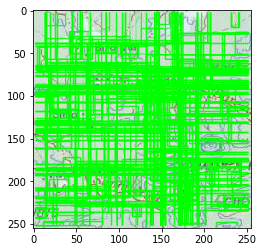

In [ ]:
#Initialize object for selective search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

Intersection over Union Function "iou" is a metric to see how well the proposed region proposals and the actual bounded texts match.
The get_iou function does the above job.

In [ ]:

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Preprocess Data

In [ ]:
'''
Perform Selective Search over each image
Across all 2000 region proposals calculate iou over the annotated region using get_iou defined above
'''
for index,value in enumerate(os.listdir(annot)):
    try:
            filename = value.split(".")[0]+".jpg"
            print(index,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,value))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
    #                             print("dsad ",counter)
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
    #                                 print("asss ",falsecounter)
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    #             print(len(train_images), len(train_labels))
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

            


covert dataset to numpy array

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
del(train_images)
del(train_labels)

In [ ]:
X_new.shape

(1647, 224, 224, 3)

Save the dataset so that we dont need to compute it again.

In [ ]:
np.save('data.npy', X_new)
np.save('datalabel.npy', y_new)

Load the data from the numpy array

In [ ]:
X_new = np.load('data.npy')
y_new = np.load('datalabel.npy')

In [ ]:
X_new.shape

(1647, 224, 224, 3)

0


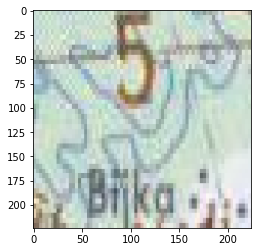

In [ ]:
plt.imshow(X_new[150])
print(y_new[150])

Importing all necessary modules to train the images over a Convolutional Neural Network along with a softmax classifier and bounding box regressor

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
'''VGG16 pretrained on imagenet weights used as the Convolutional Neural Network'''
from keras.applications.vgg16 import VGG16

Loading Imagenet weights

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 15s 0us/step


In [ ]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Initializing transfer learning and freezing layers

In [ ]:
for layers in (vggmodel.layers)[:7]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(input = vggmodel.input, output = predictions)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

Compiling new model

In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
'''
Freezing the first 15 layers of the model
Take out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict. 
Compile the model using Adam optimizer with learning rate of 0.001. 
Categorical_crossentropy as loss is used since the output of the model is categorical.'''

model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
del vggmodel

In [ ]:
from sklearn.preprocessing import LabelBinarizer

One Hot Encoding

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super(MyLabelBinarizer,self).transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
#Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
del(y_new)

Split dataset into train and test sets

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

((1482, 224, 224, 3), (165, 224, 224, 3), (1482, 2), (165, 2))


In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [ ]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [ ]:
del X_new

In [ ]:
del Y

Create Dataset

In [ ]:
'''
Keras ImageDataGenerator will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.
'''
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)

In [ ]:
del X_train
del y_train

In [ ]:
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
del X_test
del y_test

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Train Model

In [ ]:
model_final.fit_generator(generator=traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

10/10 [==============================] - 3s 297ms/step - loss: 0.0446 - accuracy: 0.9866 - val_loss: 0.0021 - val_accuracy: 1.0000

Epoch 00231: val_loss did not improve from 0.00001
Epoch 232/1000
10/10 [==============================] - 3s 329ms/step - loss: 0.0343 - accuracy: 0.9812 - val_loss: 0.0479 - val_accuracy: 0.9688

Epoch 00232: val_loss did not improve from 0.00001
Epoch 233/1000
10/10 [==============================] - 3s 317ms/step - loss: 0.0442 - accuracy: 0.9781 - val_loss: 0.1348 - val_accuracy: 0.9688

Epoch 00233: val_loss did not improve from 0.00001
Epoch 234/1000
 1/10 [==>...........................] - ETA: 1s - loss: 0.0267 - accuracy: 1.0000

KeyboardInterrupt: ignored

Load Model

In [ ]:
#from keras.models import load_model

In [ ]:
#model = files.upload()

In [ ]:
#model_final = load_model("model_vgg16.h5")

In [ ]:
!unzip test_images.zip

Archive:  test_images.zip
  inflating: test_images/714.jpg     
  inflating: test_images/711.jpg     
  inflating: test_images/713.jpg     
  inflating: test_images/708.jpg     
  inflating: test_images/702.jpg     
  inflating: test_images/704.jpg     
  inflating: test_images/706.jpg     
  inflating: test_images/701.jpg     
  inflating: test_images/710.jpg     
  inflating: test_images/703.jpg     
  inflating: test_images/705.jpg     
  inflating: test_images/715.jpg     
  inflating: test_images/712.jpg     
  inflating: test_images/707.jpg     
  inflating: test_images/709.jpg     


In [ ]:
path = "test_images"

View Output

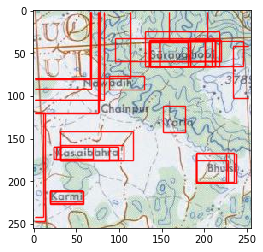

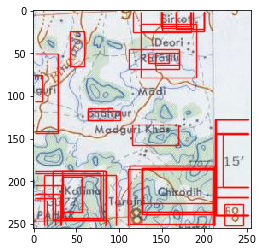

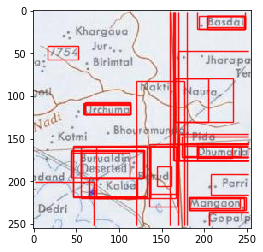

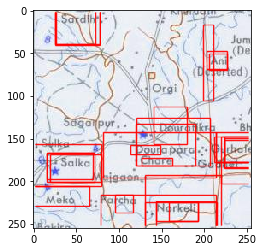

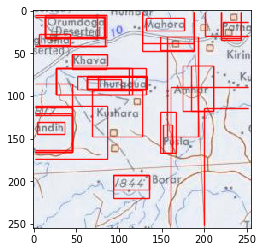

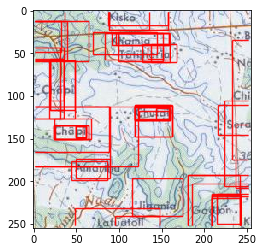

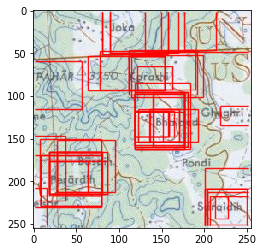

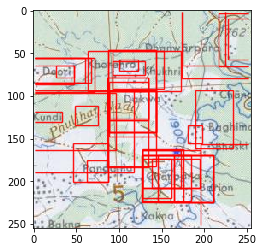

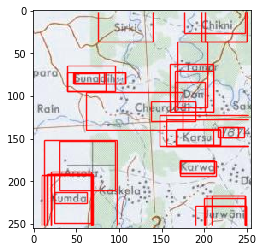

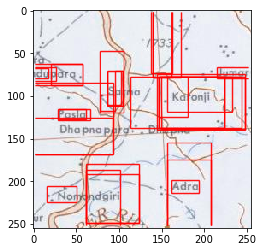

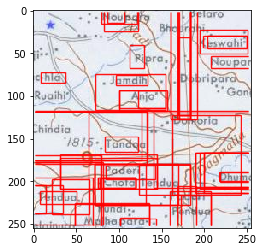

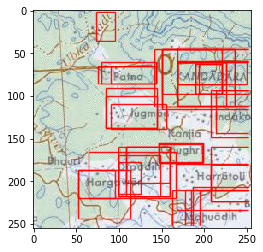

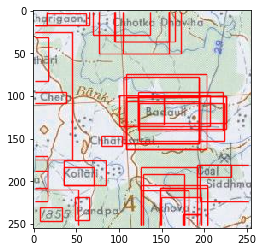

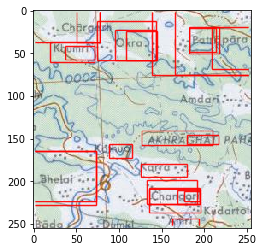

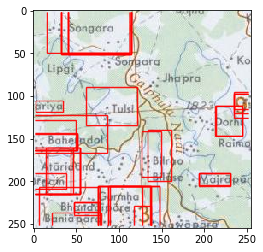

In [ ]:
'''
pass the image from selective search.
pass all the result of the selective search to the model as input using model_final.predict(img).
If the output of the model says the region to be a text feature and if the confidence is above the defined threshold 
then create bounding box on the original image on the coordinate of the proposed region.
'''
z = 1
for e,i in enumerate(os.listdir(path)):
            img = cv2.imread(os.path.join(path,i))
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = img.copy()
            for e,result in enumerate(ssresults):
                if e < 2000:
                    x,y,w,h = result
                    timage = imout[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    img = np.expand_dims(resized, axis=0)
                    out= model_final.predict(img)
                    if out[0][0] > 0.65:
                        cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
            plt.figure()
            plt.imshow(imout)
            plt.savefig(str(z)+'.jpg')
            z+=1